In [1]:
from discriminator.discriminator_wrapper import DiscriminatorWrapper
from coco_utils import load_coco_data_struct
import tensorflow as tf
import numpy as np
from generator.generator_wrapper import GeneratorWrapper, GeneratorSpec
from generator.generator_data import GeneratorData

In [2]:
def initialize_sess():
    global sess
    ruv = set(sess.run(tf.report_uninitialized_variables()))
    uv = [v for v in tf.global_variables() if v.name.split(':')[0].encode('ascii') in ruv]
    tf.variables_initializer(uv).run()
    
def reset_sess():
    global sess
    tf.reset_default_graph()
    sess.close()
    sess = tf.InteractiveSession()

def get_mean_reward(rewards):
    np_rewards = np.array(rewards)
    rows, columns = np.nonzero(np_rewards)
    indices = [i - 1 for i, val in enumerate(rows) if i > 0 and val != rows[i-1] or i == rows.shape[0]-1]
    final_rewards = np.zeros((len(indices)))
    for i, idx in enumerate(indices):
        final_rewards[i] = np_rewards[rows[idx], columns[idx]]
    return np.mean(final_rewards)
    

sess = tf.InteractiveSession()

### Load data

In [3]:
vocab_data, train_data, val_data = load_coco_data_struct()
gendata = GeneratorData()


Loaded vocab data.
Embedding <class 'numpy.ndarray'> (1004, 304) float64
Word to index <class 'dict'> 1004
Index to word <class 'list'> 1004

Loaded train data.
Captions <class 'numpy.ndarray'> (400135, 17) int32
Image indices <class 'numpy.ndarray'> (400135,) int32
Image features <class 'numpy.ndarray'> (82783, 4096) float32
Image urls <class 'numpy.ndarray'> (82783,) <U63

Loaded val data.
Captions <class 'numpy.ndarray'> (195954, 17) int32
Image indices <class 'numpy.ndarray'> (195954,) int32
Image features <class 'numpy.ndarray'> (40504, 4096) float32
Image urls <class 'numpy.ndarray'> (40504,) <U63


### Pretrain
Only run this section to pretrain the network again. This section will save the model which can then be loaded to immediately start training.

In [4]:
disc_iterations = 200
mle_iterations = 100

In [5]:
gen_spec = GeneratorSpec(input_dim=512, hidden_dim=512, output_dim=1004, rnn_activation=None,
                         image_feature_dim=4096, n_seq_steps=16,
                         embedding_init=tf.constant(gendata.word_embedding, dtype=tf.float32),
                         n_baseline_layers=2, baseline_hidden_dim=64,
                         mle_learning_rate=5e-3, pg_learning_rate=5e-4,
                         baseline_learning_rate=5e-3, batch_size=1000, epsilon=0.2)

In [6]:
disc = DiscriminatorWrapper(train_data, val_data, vocab_data)
initialize_sess()

train_loss, val_loss = disc.pre_train(sess, iter_num=disc_iterations, batch_size=1000)

iter 0, loss: -1.8046230252366513e-05
iter 20, loss: -0.02827361226081848
iter 40, loss: -0.11843439936637878
iter 60, loss: -0.18141451478004456
iter 80, loss: -0.20916174352169037
iter 100, loss: -0.23095811903476715
iter 120, loss: -0.22488659620285034
iter 140, loss: -0.24199338257312775
iter 160, loss: -0.2348962128162384
iter 180, loss: -0.24955108761787415


In [7]:
gen = GeneratorWrapper(gen_spec, disc.assign_reward)
initialize_sess()

cross_entropy, accuracy = gen.train(sess, gendata, num_iterations=mle_iterations, training_type='MLE')

iter 0, cross-entropy: 110.6014404296875, accuracy: 0.0012601260095834732
iter 10, cross-entropy: 50.80049133300781, accuracy: 0.18407602608203888
iter 20, cross-entropy: 44.62212371826172, accuracy: 0.307664692401886
iter 30, cross-entropy: 40.0314826965332, accuracy: 0.33152419328689575
iter 40, cross-entropy: 37.833858489990234, accuracy: 0.3510152995586395
iter 50, cross-entropy: 35.952789306640625, accuracy: 0.3672078251838684
iter 60, cross-entropy: 34.517425537109375, accuracy: 0.3738401234149933
iter 70, cross-entropy: 33.07387161254883, accuracy: 0.3831969201564789
iter 80, cross-entropy: 32.23009490966797, accuracy: 0.39173316955566406
iter 90, cross-entropy: 31.571643829345703, accuracy: 0.3964470624923706
iter 100, cross-entropy: 30.851285934448242, accuracy: 0.41426926851272583


In [8]:
# Saves the model into a models/ folder which is excluded from git using the .gitignore
gen.save(sess, "pretrained2-mle%d-disc%d" % (mle_iterations, disc_iterations))

In [9]:
reset_sess()

### Load Model
Load an existing model that contains both a discrminator and generator (policy gradient) network. If the model has contained a policy gradient LSTM before, then set is_PG to true.

In [6]:
dir_name="models"
model_name = "pretrained2-mle%d-disc%d" % (mle_iterations, disc_iterations)

# Load discriminator
disc = DiscriminatorWrapper(train_data, val_data, vocab_data, load_session=sess,
                            saved_model_name=model_name, model_base_dir=dir_name)

# Load generator
gen = GeneratorWrapper(gen_spec, disc.assign_reward, load_model=True, reward_to_go=False, use_discriminator_reward=True)

initialize_sess()

INFO:tensorflow:Restoring parameters from models/pretrained2-mle100-disc200


### Train
Alternate between running the two cells below or enclose their contents in a loop. The former is probably wiser since sometimes either side will require fewer or more iterations.

In [ ]:
print("ready, set, go!")

ready, set, go!


Mean Reward: 0.718 | a fire hydrant in a large of <UNK> <UNK> <END>
Mean Reward: 0.472 | a small light where a table has a baseball field <END>
Mean Reward: 0.379 | a large clock tower with two trees and <UNK> <END>
Mean Reward: 0.387 | a small room with a wooden shower vanity and black and white large white counter <END>
Mean Reward: 0.401 | a tree with some <UNK> <UNK> in a blue sky <END>
Mean Reward: 0.410 | a small two bus is standing on a street with a station <END>
Mean Reward: 0.450 | a large black dog sitting on a wooden <UNK> and a wall <END>
Mean Reward: 0.495 | a large skier is pulling a <UNK> in the water as a large <UNK> behind his
Mean Reward: 0.505 | a large black blue and white dog posing up of a boat <UNK> up up him
Mean Reward: 0.568 | a big boy is riding a skateboard in the water <END>
Mean Reward: 0.511 | a dark pizza is walking through a <UNK> <UNK> <UNK> with a <UNK> on the corner
Mean Reward: 0.448 | a silver <UNK> toddler in others others others others others ot

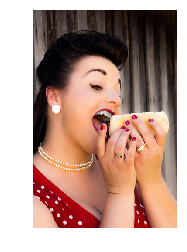

batter          0.9969447255134583
is              0.0007553207105956972
above           0.002745778998360038
a               0.0012728142319247127
red             0.00030544036417268217
bag             0.0007150943856686354
with            0.002615543082356453
a               0.002094780094921589
round           0.0018210314447060227
couch           0.004837811924517155
<END>           2.1913265300099738e-05
- - - -
Mean Reward: 0.017 | there kite full full full full dog looking out others others others others others others others
Mean Reward: 0.016 | there view dog kite looking others others others others others others others others others others others
Mean Reward: 0.021 | there view kite full full full full full full full full dog looking others others others
Mean Reward: 0.019 | there view full dog looking dog looking others others others others others others others others others
Mean Reward: 0.018 | there view full full dog looking out others others others others others others ot

Mean Reward: 0.570 | there large large gray gray gray gray horse riding a dog <UNK> a black dog wearing
Mean Reward: 0.561 | there large sandwich there there sandwich there there sandwich there there laying there there laying others
Mean Reward: 0.551 | there large room there room there room there room there room there room there room there
Mean Reward: 0.555 | there large large gray riding riding others riding others others riding others others others others others
Mean Reward: 0.476 | there large riding riding others riding others riding others others riding others others others others others
Mean Reward: 0.469 | there large large large large large large large large large large large large large large large
Mean Reward: 0.483 | there large large large riding riding others riding others others riding others others others others others
Mean Reward: 0.581 | there large sandwich there there cat guy <UNK> there cute sandwich there guy tomatoes lamp sauce
Mean Reward: 0.554 | there large l

Mean Reward: 0.472 | there large large large large large large large large large large large large large gray horse
Mean Reward: 0.540 | there large large large gray gray gray gray gray gray gray gray gray gray gray gray
Mean Reward: 0.447 | there large large large large large large large large large large large large large room watching
Mean Reward: 0.356 | there large large large room cat <UNK> kitten looking cat <UNK> looking cute room cat watching
Mean Reward: 0.453 | there large large large large large room there room watching watching room watching watching watching watching
Mean Reward: 0.388 | there large out out out out out out out out out room out out room watching
Mean Reward: 0.447 | there large large large out out out out out out out out out room out out
Mean Reward: 0.432 | there large gray gray gray gray gray gray gray gray gray gray gray out gray gray
Mean Reward: 0.444 | there large large large sandwich out out out out out out out out out out out
Mean Reward: 0.509 | t

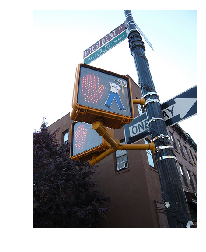

there           0.9981667995452881
large           0.002295740647241473
large           0.000411032437114045
large           0.0003272870962973684
large           0.0006114026182331145
large           0.0010331686353310943
large           0.0013463174691423774
gray            0.001808720175176859
dirt            0.0004112425376661122
dirt            0.00020293045963626355
room            0.00036391467438079417
there           0.001725106849335134
horse           0.008791250176727772
<UNK>           0.0020406933035701513
umpire          0.0030849971808493137
umpire          0.05570364370942116
- - - -
Mean Reward: 0.035 | there large gray gray gray gray gray gray gray gray gray gray gray gray gray gray
Mean Reward: 0.032 | there large large sandwich out out out out out out out out mouth out skier sticking
Mean Reward: 0.063 | there large large sandwich out out out out hand hand hand hand hand hand hand hand
Mean Reward: 0.068 | there large gray gray gray gray gray gray gray gray gray gr

Mean Reward: 0.374 | there out there there parked parked parked parked parked parked parked parked parked parked parked parked
Mean Reward: 0.402 | there out child child child girl girl putting hand girl girl perched girl market covered set
Mean Reward: 0.399 | there out child child girl rock rock rock rock rock rock bus parked parked parked parked
Mean Reward: 0.399 | there sandwich fork sandwich fork fork child there sandwich fork there out out out out out
Mean Reward: 0.367 | there out child child girl girl perched hand girl stand perched in several women smiles men
Mean Reward: 0.402 | there out child child girl girl girl girl girl perched and market monitors girl three being
Mean Reward: 0.409 | there out child child child girl girl girl girl covered being perched living room girl poses
Mean Reward: 0.397 | there out child child child girl girl trying bedroom girl perched set several parked three wearing
Mean Reward: 0.432 | there child child child child girl girl girl girl girl p

In [ ]:
for cycle in range(100):
    pg_iterations = 5
    captions = []
    probs = []
    indexes = []
    rewards = []
    while pg_iterations > 0:
        caption, prob, index, reward = gen.train(sess, gendata.shuffle(), 5, training_type='PPO')
        mean_reward = get_mean_reward(reward)
        print("Mean Reward: %.3f | %s" % (mean_reward, caption[-1]))
        if mean_reward > 0.6 + cycle * 0.002:
            captions.extend(caption)
            probs.extend(prob)
            indexes.extend(index)
            rewards.extend(reward)
            pg_iterations -= 1

    disc_iterations = 80
    online_all_loss, online_val_loss = disc.online_train(sess, iter_num=disc_iterations, img_idxs=np.array(indexes),
                                                         caption_sentences=captions)

    disc.assign_reward(sess, np.array(indexes)[0:1], captions[0:1], image_idx_from_training=True, to_examine=True)
    
    if cycle % 5 == 0:
        gen.save(sess, "ppo-discgen-checkpoint-%d" % cycle)

### Save Model

In [12]:
gen.save(sess, "full-discriminator-generator")